# Analyze Sentiment for Forum Data
This notebook loads the sentiment data and explores results

## Data Sources
- youbemom-merged.db (with sentiment scores from 2.0-Sentiment-Create_Scores.ipynb)

## Changes
- 2020-12-13: Created

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
 - subforum: subforum of post
 - dne: post does not exist
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post
 - subforum: subforum of post
 - deleted: has post been deleted
 - text: title + body
 - text_no_url: text without urls
 - neg_sentiment
 - neu_sentiment
 - pos_sentiment
 - compound_sentiment
 - neg_sentiment_no_url
 - neu_sentiment_no_url
 - pos_sentiment_no_url
 - compound_sentiment_no_url

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words
- Robustness checks of different samples
- Scrape the rest of December so frequency counts are right

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols
from youbemom import create_connection

## Functions

In [2]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

In [17]:
def create_dates(df):
    """ create date variables
    :param df: data frame
    :return: formatted data frame
    """
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['before'] = df['date_created'] <= pd.Timestamp(2020,2,28)
    df['during'] = df['date_created'] >= pd.Timestamp(2020,4,1)
    df['march'] = ~df['before'] & ~df['during']
    df.loc[df['before'], 'period'] = 'before'
    df.loc[df['march'], 'period'] = 'march'
    df.loc[df['during'], 'period'] = 'during'
    df['weekday'] = df['date_created'].dt.day_name()
    df['week_n'] = df['date_created'].dt.isocalendar().week
    df['weekday_n'] = df['date_created'].dt.day
    df['month'] = df['date_created'].dt.month_name()
    df['month_n'] = df['date_created'].dt.month
#     df['ymd'] = df['date_created'].dt.to_period('D')
    return df

In [5]:
def compare_parent_child(df):
    parents = df[df["is_parent"]]
    parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children = df[~df["is_parent"]]
    children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children_ave = children.groupby("family_id", as_index=False).mean()
    compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
    compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
    compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
    compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
    return compare

In [6]:
def season_sentiment(df, name, var):
    grouping_ave = df.groupby([var])['compound_sentiment'].mean()
    path_sen = path_parent / "clean_data" / "sentiment_{0}_{1}.csv".format(name, var)
    path_sen = str(path_sen)
    grouping_ave.to_csv(path_sen)
    print(grouping_ave)

In [7]:
def season_freq(df, name, var):
    grouping_freq = df.groupby(var)[var].count()
    path_freq = path_parent / "clean_data" / "frequency_{0}_{1}.csv".format(name, var)
    path_freq = str(path_freq)
    grouping_freq.to_csv(path_freq)
    print(grouping_freq)

In [80]:
def ave_sent_day(df):
    daily_ave = df[['date_created','compound_sentiment']].copy()
    daily_ave = daily_ave.set_index('date_created')
    daily_ave = daily_ave.resample('D').mean().dropna(how='all')
    daily_ave['period'] = "March"
    daily_ave.loc[daily_ave.index <= pd.Timestamp(2020,2,28), 'period'] = "Before"
    daily_ave.loc[daily_ave.index >= pd.Timestamp(2020,4,1), 'period'] = "During"
    return daily_ave

In [134]:
def daily_freq(df):
    freq = df[['date_created', 'compound_sentiment']].copy()
    freq = freq.set_index('date_created')
    freq = freq.resample('D').size().dropna(how='all').to_frame()
    freq.columns = ['daily_count']
    freq['period'] = "March"
    freq.loc[freq.index <= pd.Timestamp(2020,2,28), 'period'] = "Before"
    freq.loc[freq.index >= pd.Timestamp(2020,4,1), 'period'] = "During"
    return freq

## File Locations

In [9]:
p = Path.cwd()
path_parent = p.parents[0]

In [10]:
path_db = path_parent / "database" / "youbemom-merged.db"
path_db = str(path_db)

## Load Data
Counts of posts in each subforum

In [11]:
counts_sql = '''
    SELECT subforum, COUNT(family_id), MIN(date_created), MAX(date_created)
    FROM posts
    GROUP BY subforum
'''

In [12]:
conn = create_connection(path_db)
counts = pd.read_sql_query(counts_sql, conn)

In [13]:
counts.head(16)

,subforum,COUNT(family_id),MIN(date_created),MAX(date_created)
0,boston,230,2018-01-27 17:21:00,2020-11-23 00:23:00
1,chicago,193,2018-03-05 14:40:00,2020-12-08 13:50:30
2,elementary,3543,2013-12-05 21:43:00,2020-11-30 20:52:00
3,expecting,872,2018-01-24 02:43:00,2020-11-23 21:01:00
4,los-angeles,263,2018-01-09 20:58:00,2020-12-02 02:07:00
5,new-york-city,6297,2018-01-07 11:37:00,2020-11-28 03:45:00
6,newborn,2036,2013-11-06 20:55:00,2020-11-29 23:39:00
7,nyc-schools,2211,2018-01-01 16:03:00,2020-12-04 16:49:00
8,preschool,3000,2013-12-10 03:58:00,2020-11-23 14:34:00
9,single-parents,337,2018-02-07 11:29:00,2020-11-23 16:22:00


Special needs subforum

In [14]:
sn_sql = ''' SELECT * FROM posts WHERE subforum="special-needs" '''

In [15]:
sn = pd.read_sql_query(sn_sql, conn)

In [18]:
sn = create_dates(sn)

In [20]:
sn.head()

,id,family_id,message_id,parent_id,date_recorded,date_created,title,body,subforum,deleted,...,before,during,march,period,weekday,week_n,weekday_n,month,month_n,ymd
0,1905,173,104900532,,12-02-2020 10:51:54,2018-02-18 20:04:00,Son has mild Sensory Issuesany privates in Man...,,special-needs,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
1,1906,173,104900615,104900532,12-02-2020 10:51:54,2018-02-18 20:09:00,That’s all he has going on?,,special-needs,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
2,1907,173,104900681,104900615,12-02-2020 10:51:54,2018-02-18 20:13:00,So far. Started some NP testing to determine m...,,special-needs,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
3,1908,173,104900694,104900681,12-02-2020 10:51:54,2018-02-18 20:14:00,well how old is he?,,special-needs,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
4,1909,173,104900704,104900694,12-02-2020 10:51:54,2018-02-18 20:14:00,just turned 5,,special-needs,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18


Toddler subforum: generate a 10% sample of family_ids to make processing easier

In [21]:
td_ids_sql = ''' SELECT family_id FROM threads WHERE subforum="toddler" '''

In [22]:
td_ids = pd.read_sql_query(td_ids_sql, conn)

In [23]:
id_10per_sample = td_ids.sample(frac = 0.1, random_state = 281)

In [24]:
temp_table_sql = ''' CREATE TEMPORARY TABLE temp(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, family_id INTEGER); '''

In [25]:
cur = conn.cursor()
cur.execute(temp_table_sql)

In [26]:
id_10per_sample.to_sql('temp', conn, if_exists='append', index=False)

In [27]:
td_sql = ''' 
    SELECT * 
    FROM posts 
    WHERE subforum="toddler" 
        AND family_id IN (SELECT family_id FROM temp)
'''

In [30]:
td = pd.read_sql_query(td_sql, conn)

In [31]:
td = create_dates(td)

In [32]:
td.head()

,id,family_id,message_id,parent_id,date_recorded,date_created,title,body,subforum,deleted,...,before,during,march,period,weekday,week_n,weekday_n,month,month_n,ymd
0,15,4,104898750,,12-02-2020 10:44:27,2018-02-18 18:20:00,"Speaking of marijuana, High Maintenance on hbo...",,toddler,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
1,111,14,104898836,,12-02-2020 10:44:39,2018-02-18 18:28:00,Second day Assad mom is again on trump's side.,,toddler,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
2,112,14,104898851,104898836,12-02-2020 10:44:39,2018-02-18 18:28:00,"I'm ""Assad mom"" and I'm not on Trump's side. I...",,toddler,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
3,113,14,104898881,104898851,12-02-2020 10:44:39,2018-02-18 18:30:00,You murdered babies with poison gassed. You ca...,,toddler,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18
4,114,14,104898901,104898881,12-02-2020 10:44:39,2018-02-18 18:32:00,I forgive you for your ignorance. You're too u...,,toddler,0,...,True,False,False,before,Sunday,7,18,February,2,2018-02-18


## Compare Sentiment

### 1. Subsets in correct date range: 2018-01-01 to 2020-11-30

In [33]:
mask = (td['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (td['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
td_sub = td.loc[mask]

In [34]:
mask = (sn['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (sn['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
sn_sub = sn.loc[mask]

### 2. Comparing sentiment before and during pandemic with a t-test

In [38]:
for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
    print(name)
    ttest_sentiment(df, 'neg_sentiment')
    ttest_sentiment(df, 'neu_sentiment')
    ttest_sentiment(df, 'pos_sentiment')
    ttest_sentiment(df, 'compound_sentiment')
    print("\n")

special-needs


     variable    before    during statistic    pvalue
neg_sentiment  0.065994  0.070662 -2.666893  0.007673


     variable    before    during statistic    pvalue
neu_sentiment  0.782411  0.767375 +4.311199  0.000016


     variable    before    during statistic    pvalue
pos_sentiment  0.118489  0.116065 +1.041510  0.297674


          variable    before    during statistic    pvalue
compound_sentiment  0.125809  0.111455 +2.330966  0.019783


toddler


     variable    before    during statistic    pvalue
neg_sentiment  0.087440  0.088576 -3.806125  0.000141


     variable    before    during statistic    pvalue
neu_sentiment  0.772217  0.769809 +5.174986  0.000000


     variable    before    during statistic    pvalue
pos_sentiment  0.124902  0.119395 +15.393640  0.000000


          variable    before    during statistic    pvalue
compound_sentiment  0.056082  0.041731 +20.995239  0.000000




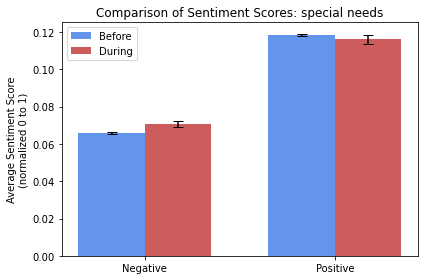

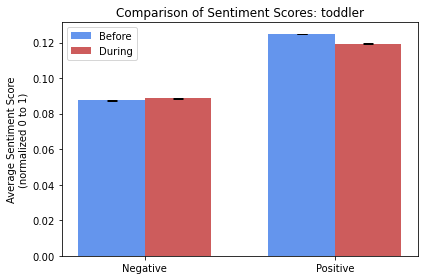

In [39]:
for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
    fig, ax = plt.subplots()
    width = 0.35
    sentiments = ['Negative', 'Positive']
    x_pos = np.arange(len(sentiments))

    before_mean = [df["neg_sentiment"][df['before']].mean(),
                   df["pos_sentiment"][df['before']].mean()]
    before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
                 df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
    during_mean = [df["neg_sentiment"][df['during']].mean(),
                   df["pos_sentiment"][df['during']].mean()]
    during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
                 df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

    rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                    label='Before', capsize=5, color="cornflowerblue")
    rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                    label='During', capsize=5, color="indianred")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
    ax.set_title('Comparison of Sentiment Scores: {}'.format(name))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sentiments)
    ax.legend()
    fig.tight_layout()
#     plt.savefig('../plots/sentiment_neg_pos.png')
    plt.show()

### 3. Comparing sentiment of parent and child posts

In [ ]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    compare = compare_parent_child(df)
    est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
    print(est_pos.summary())
    est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
    print(est_neg.summary())
    est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
    print(est_compound.summary())

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

### 4. Compare density of compound sentiment

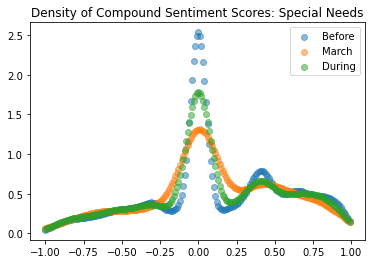

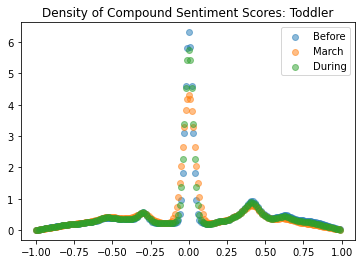

In [42]:
for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
    density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
    density_march = kde.gaussian_kde(df["compound_sentiment"][df['march']])
    density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
    x = np.arange(-1.0, 1.0, 0.01)
    plt.scatter(x, density_before(x), alpha=0.5, label="Before")
    plt.scatter(x, density_march(x), alpha=0.5, label="March")
    plt.scatter(x, density_during(x), alpha=0.5, label="During")
    plt.legend(loc="upper right")
    plt.title('Density of Compound Sentiment Scores: {}'.format(name))
    plt.show()

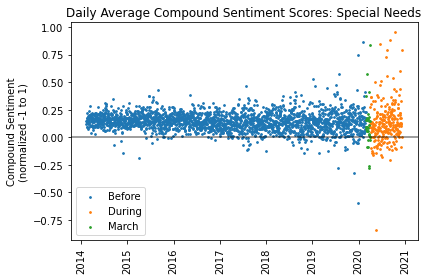

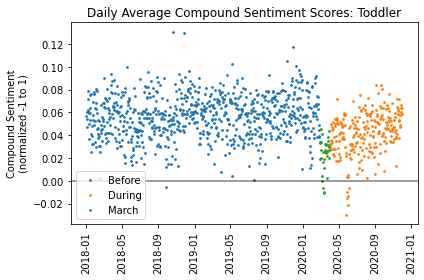

In [137]:
size = 3
for name, df in {"Special Needs":sn, "Toddler":td_sub}.items():
    daily_ave = ave_sent_day(df)
    groups = daily_ave.groupby('period')
    for period, group in groups:
        plt.scatter(group.index, group.compound_sentiment, label=period, s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
    plt.title('Daily Average Compound Sentiment Scores: {}'.format(name))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 5. Compare post frequency over same period for special needs and toddler subforums

Frequency

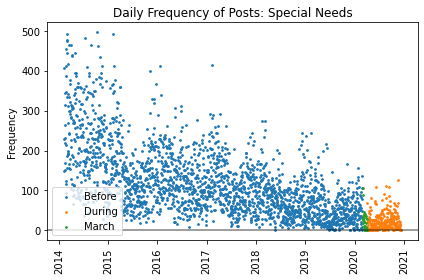

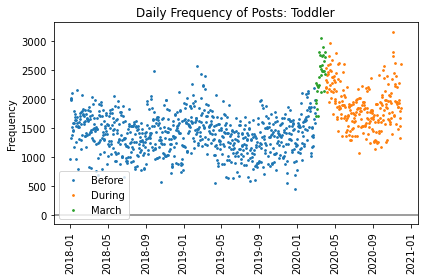

In [138]:
size = 3
for name, df in {"Special Needs":sn, "Toddler":td_sub}.items():
    freq = daily_freq(df)
    groups = freq.groupby('period')
    for period, group in groups:
        plt.scatter(group.index, group.daily_count, label=period, s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.title('Daily Frequency of Posts: {}'.format(name))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()